In [1]:
# leave this stuff alone (but run it)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from analysisTools import *
import pickle

In [2]:
cd ~/Desktop/alyssa_1080p/200924_sham_pre

/Users/iwoods/Desktop/alyssa_1080p/200924_sham_pre


In [3]:
# load the data ... need to change just the folder name below (before the / )
d = loadData('xy2')
print(np.shape(d)) # rows, columns. Columns should be # of fish. Rows should be time (s) x 30 (framerate)

Loading .npy files
(26977, 97)


In [4]:
# enter the different kinds of fish here
dmso = np.array([1, 3, 5, 7, 10, 13, 16, 18, 20, 22, 26, 32, 34, 36]) # sham
mefloquine = np.array([2, 4, 6, 8, 12, 15, 17, 19, 21, 25, 27, 33, 35, 40 ]) # sham

In [5]:
print(dmso)

[ 1  3  5  7 10 13 16 18 20 22 26 32 34 36]


## Quality control

In [6]:
# looking at a bit of the data, 14 fish, 15 frames (0.5 second)
print(d[:30,14:28])

[[1259. 1459. 1659.  259.  459.  659.  859. 1059. 1259. 1459. 1659.  259.
   459.  659.]
 [1259. 1459. 1659.  259.  459.  659.  859. 1059. 1259. 1459. 1659.  259.
   459.  659.]
 [1259. 1459. 1659.  259.  459.  659.  859. 1059. 1259. 1459. 1659.  259.
   459.  659.]
 [1259. 1459. 1659.  259.  459.  659.  859. 1059. 1259. 1459. 1659.  259.
   459.  659.]
 [1259. 1459. 1659.  259.  459.  659.  877. 1059. 1259. 1459. 1659.  259.
   459.  659.]
 [1259. 1459. 1659.  259.  459.  659.  895. 1059. 1259. 1459. 1659.  259.
   459.  659.]
 [1259. 1459. 1659.  259.  459.  659.  904. 1059. 1259. 1459. 1659.  259.
   459.  659.]
 [1259. 1459. 1659.  259.  459.  659.  915. 1059. 1259. 1459. 1659.  259.
   459.  659.]
 [1259. 1459. 1659.  259.  459.  659.  911. 1059. 1259. 1459. 1659.  259.
   459.  659.]
 [1259. 1459. 1659.  259.  459.  659.  906. 1059. 1259. 1459. 1659.  259.
   459.  659.]
 [1259. 1459. 1659.  259.  459.  659.  909. 1059. 1259. 1459. 1659.  259.
   459.  659.]
 [1259. 1459. 1659.  

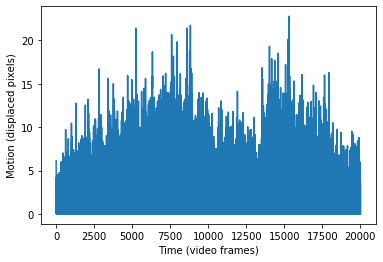

In [43]:
# show overall motion ... any bumps?
timeVmotion = np.mean(d,1)
plt.plot(timeVmotion)
plt.xlabel('Time (video frames)')
plt.ylabel('Motion (displaced pixels)')
plt.show()

In [57]:
# ONLY IF THERE IS A BUMP! remove outlier frames if necessary
# identify outlier frames 
stdThreshold = 10
overallStd = np.std(timeVmotion)
overallMean = np.mean(timeVmotion)
outlierTimes = np.where(timeVmotion >= overallMean + (stdThreshold * overallStd))
print('outliers: ',outlierTimes)

# for now, set to mean activity [later - set to prior or next frame]
d[outlierTimes,:] = overallMean

outliers:  (array([], dtype=int64),)


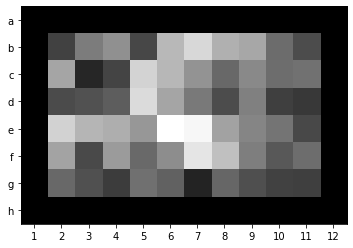

In [44]:
# show overall activity in plate ... are there any dead fish that should be omitted?
# is the difference in illumination across the plate causing big problems?
totalActivity = np.sum(d,0)

plateView = np.reshape(totalActivity,(8,12))
plt.imshow(plateView, interpolation='nearest', cmap = 'gray')
columns = np.array([1,2,3,4,5,6,7,8,9,10,11,12])
rows = ['a','b','c','d','e','f','g','h']
plt.xticks(columns-1, columns)
plt.yticks([0,1,2,3,4,5,6,7],rows) # or other way?
plt.show()

## Run the analysis

In [45]:
# add time vector 
frameRate = 30.0
numFrames = np.shape(d)[0]
totalSecs =  numFrames / frameRate
timeVec = np.linspace(0,totalSecs,numFrames) # this is in seconds (and fractions of seconds)

In [46]:
# bin the data
binSizeInSeconds = 5
numBins = int(math.floor(totalSecs / binSizeInSeconds)) - 1
binStarts = [int(b * binSizeInSeconds * frameRate) for b in range(numBins)]
binnedTime = np.array([timeVec[b] for b in binStarts])
binnedData = np.zeros([len(binStarts),np.shape(d)[1]])
for b in range(len(binStarts)-1): # last bin omitted b/c incomplete
    binnedData[b,:] = np.sum(d[binStarts[b]:binStarts[b+1],:],axis=0)
print(np.shape(binnedData))

(132, 96)


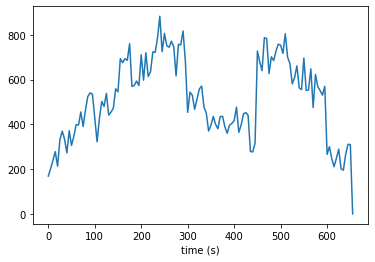

In [47]:
# plot of binned data, entire plate
meanActivity = np.mean(binnedData,1)
plt.plot(binnedTime, meanActivity)
plt.xlabel('time (s)')
plt.show()

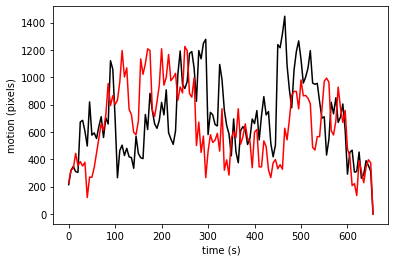

In [48]:
# plot of binned data, control vs test
controlData = binnedData[:,controls]
testData = binnedData[:,testfish]
meanControl = np.mean(controlData,1)
meanTest = np.mean(testData,1)
plt.plot(binnedTime,meanControl,'k')
plt.plot(binnedTime,meanTest,'r')
plt.xlabel('time (s)')
plt.ylabel('motion (pixels)')
plt.show()

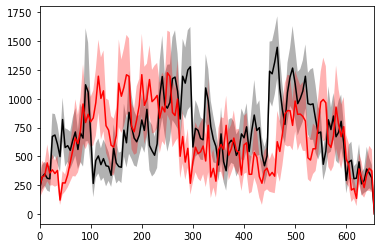

In [49]:
# plot of binned data, control vs test, with fill = +/- standard error of the mean
f,a = plt.subplots(1,1)

a.plot(binnedTime,meanControl,'k')
se = stde(controlData,1)
a.fill_between(binnedTime, meanControl-se, meanControl+se, alpha = 0.3, facecolor = 'k', edgecolor = '')

a.plot(binnedTime,meanTest,'r')
se = stde(testData,1)
a.fill_between(binnedTime, meanTest-se, meanTest+se, alpha = 0.3, facecolor = 'r', edgecolor = '')

a.set_xlim([ binnedTime[0], binnedTime[-1]  ])
plt.show()

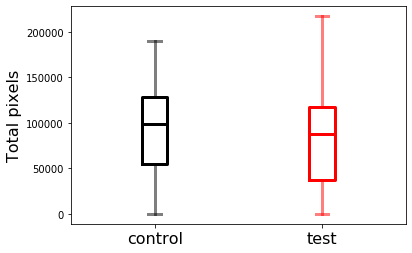

In [50]:
# compare total motion between the two groups
totalControl = np.sum(controlData,0)
totalTest = np.sum(testData,0)
boxData = [totalControl,totalTest]
bp = plt.boxplot(boxData)
bp = formatBoxColors(bp, ['k','r'])
plt.ylabel('Total pixels',fontsize=16)
plt.xticks([1,2],['control','test'],fontsize=16)
plt.show()

In [51]:
print('kw test')
pvals = statsFromBoxData(boxData,'k')

print('t-test')
pvals = statsFromBoxData(boxData,'t')

kw test
1 vs. 2: 0.617

t-test
1 vs. 2: 0.668



In [52]:
print(totalTest)

[107530.  62345.  66373. 159052. 121622. 116177.      0. 111389.  49578.
      0. 150954. 217023.      0.  91394. 198528.  94965.  84236.  66121.
      0.      0.]


In [53]:
pickle.dump(totalTest,open('100test.p','wb'))
pickle.dump(totalControl,open('100controls.p','wb'))

# load saved data and compare

In [54]:
noMO_before_test    = pickle.load(open('0test.p','rb'))
noMO_before_control = pickle.load(open('0controls.p','rb'))
MO_before_test    = pickle.load(open('100test.p','rb'))
MO_before_control = pickle.load(open('100controls.p','rb'))

In [35]:
print(before)

[ 49360.  85787.  29293. 103470. 118093. 112529.      0.  60006.  64370.
      0. 105692.  72202.      0.  67496. 114606.  18236.  57881.  46298.
      0.      0.]


In [55]:
before_per_min_test = noMO_before_test / 30
before_per_min_control = noMO_before_control / 30
during_per_min_test = MO_before_test / 10
during_per_min_control = MO_before_control / 10

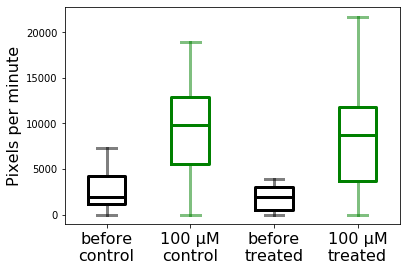

In [59]:
boxData = [before_per_min_control,during_per_min_control,before_per_min_test,during_per_min_test]

bp = plt.boxplot(boxData)
bp = formatBoxColors(bp, ['k','g','k','g'])
plt.ylabel('Pixels per minute',fontsize=16)
plt.xticks([1,2,3,4],['before\ncontrol','100 µM\ncontrol','before\ntreated','100 µM\ntreated'],fontsize=16)
plt.show()

In [69]:
before = pickle.load(open('before_MO.p','rb'))
low = pickle.load(open('1uM_totalMotion.p','rb'))
medium = pickle.load(open('10uM_totalMotion.p','rb'))
high = pickle.load(open('100uM_totalMotion.p','rb'))

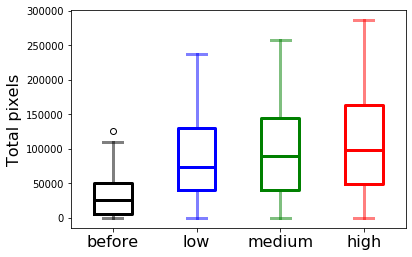

In [70]:
boxData = [before,low,medium,high]
bp = plt.boxplot(boxData)
bp = formatBoxColors(bp, ['k','b','g','r'])
plt.ylabel('Total pixels',fontsize=16)
plt.xticks([1,2,3,4],['before','1 µM','10 uM','100 uM'],fontsize=16)
plt.show()